In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. Load the data

In [2]:
metadata = 'ISIC_2020_Training_GroundTruth_v2.csv'
duplicate_list = 'ISIC_2020_Training_Duplicates.csv'

metadata_df = pd.read_csv(os.path.join("data", metadata))
duplicate_df = pd.read_csv(os.path.join("data", duplicate_list))

### 2. Remove duplicates
The dataset indicated that in the larger image set, there are 425 duplicates. These are captured in duplicate_csv In form of image_name_1, image_name_2. 

In [3]:
duplicate_names = duplicate_df['image_name_2']

print(len(metadata_df))
metadata_df = metadata_df[~metadata_df['image_name'].isin(duplicate_names)]
print(len(metadata_df))


33126
32701


### Find patient records with the same body location present in multiple appointments

In [5]:
# Group by 'patient_id' and 'anatom_site_general_challenge'
grouped = metadata_df.groupby(['patient_id', 'anatom_site_general_challenge'])

# Filter groups to those with more than one unique 'age_approx' value
filtered_groups = grouped.filter(lambda x: x['age_approx'].nunique() > 1)

# Get unique patient IDs from the filtered groups
unique_patients = filtered_groups['patient_id'].unique()

# Use this filtered list of patient_ids to filter the original DataFrame
metadata_filtered_df = metadata_df[metadata_df['patient_id'].isin(unique_patients)]

Patients with images from the same body location at different ages: 936


In [6]:
print(f"after filtering remaining records: {len(metadata_filtered_df)}. Unique patients: {len(metadata_filtered_df['patient_id'].unique())}.")

after filtering remaining records: 16065. Unique patients: 936.


### 4. Visualize the patient breakdown

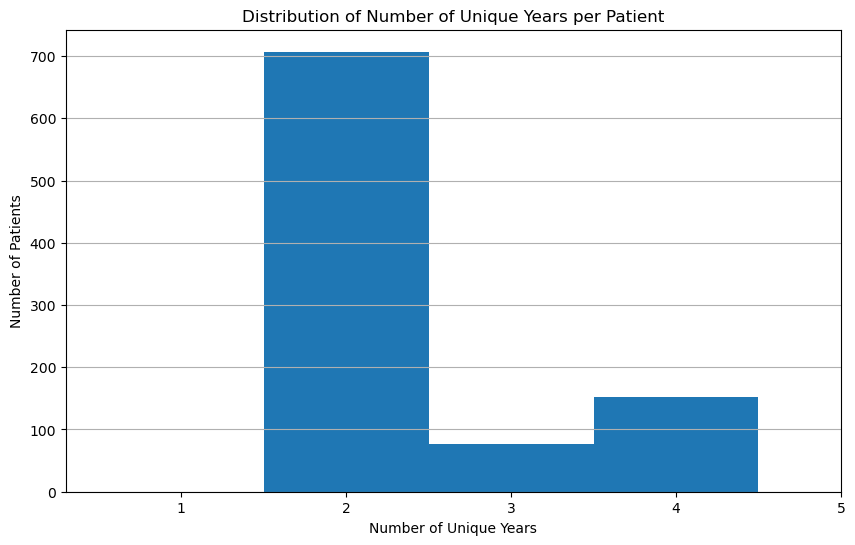

In [7]:
# Group by 'patient_id' and 'age_approx', then count unique ages per patient
df_unique_ages_per_patient = metadata_filtered_df.groupby('patient_id')['age_approx'].nunique().reset_index(name='unique_years')

# Distribution of unique years per patient
plt.figure(figsize=(10, 6))
plt.hist(df_unique_ages_per_patient['unique_years'], bins=range(1, df_unique_ages_per_patient['unique_years'].max() + 1), align='left')
plt.title('Distribution of Number of Unique Years per Patient')
plt.xlabel('Number of Unique Years')
plt.ylabel('Number of Patients')
plt.xticks(range(1, df_unique_ages_per_patient['unique_years'].max() + 1))
plt.grid(axis='y')
plt.show()

### 5. Find patients who went from benign to malignant
We have images from multiple locations per patient. Each image is annotated with anatom_site_general_challenge. We can use this to find patients who went from benign to malignant.

In [8]:
# Initialize a list to hold patients with changes from benign to malignant at the same site
patients_with_changes_same_site = []

# Iterate over each patient to check their records
for patient_id in metadata_filtered_df['patient_id'].unique():
    patient_records = metadata_filtered_df[metadata_filtered_df.patient_id == patient_id]
    
    # We need to check each anatomical site separately for this patient
    for site in patient_records['anatom_site_general_challenge'].unique():
        site_records = patient_records[patient_records['anatom_site_general_challenge'] == site]
        
        # Now check if there are both benign and malignant diagnoses at this site
        if 'benign' in site_records['benign_malignant'].values and 'malignant' in site_records['benign_malignant'].values:
            patients_with_changes_same_site.append((patient_id, site))

# Calculate the unique number of patients (since one patient could have multiple sites)
unique_patients_with_changes = len(set([patient for patient, site in patients_with_changes_same_site]))

print(f"Number of unique patients with moles changing from benign to malignant at the same anatomical site: {unique_patients_with_changes}")


Number of unique patients with moles changing from benign to malignant at the same anatomical site: 204


### 6. Save the filtered metadata

In [9]:
metadata_filtered_df.to_csv(os.path.join('data', 'metadata_filtered.csv'))